# License Plate Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="
    https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/README.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>
<br>
<br>

### Install Application Dependecies 

In [31]:
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/requirements.txt
!pip -q --no-color install -r requirements.txt

File 'requirements.txt' already there; not retrieving.


Usage:   
  pip <command> [options]

no such option: -n


### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [26]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.

nohup eva_server > eva.log 2>&1 &

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Register License Plate Extraction UDF

In [27]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/ocr_extractor.py"
cursor.execute("DROP UDF LicensePlateExtractor;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS LicensePlateExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'license_plate_extractor.py';
      """)
response = cursor.fetch_all()
print(response)

File 'ocr_extractor.py' already there; not retrieving.

@status: ResponseStatus.SUCCESS
@batch: 
                                                 0
0  UDF LicensePlateExtractor successfully dropped
@query_time: 0.019902887986972928
@status: ResponseStatus.SUCCESS
@batch: 
                                                                0
0  UDF LicensePlateExtractor successfully added to the database.
@query_time: 6.197657027980313


## Download Images for License Plate Recognition

In [28]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/test_image_1.png"
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/test_image_2.png"
!wget -nc "https://raw.githubusercontent.com/femioladeji/License-Plate-Recognition-Nigerian-vehicles/master/test_images/car10.jpg"
!wget -nc "https://raw.githubusercontent.com/femioladeji/License-Plate-Recognition-Nigerian-vehicles/master/test_images/car6.jpg"
!wget -nc "https://im.ezgif.com/tmp/ezgif-1-c32008dd2a-jpg/ezgif-frame-001.jpg"

# DOWNLOAD ADDITIONAL IMAGES IF NEEDED AND LOAD THEM

#for i, plates in enumerate(car_plates):
#    for j, plate in enumerate(plates):
i=0
j=0
file_name = "frame" + str(i)+ "_plate" + str(j) + ".png"
print(file_name)
cursor.execute('DROP TABLE IF EXISTS MyImages')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "' + file_name + '" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "test_image_1.png" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "test_image_2.png" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "car10.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "car6.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "ezgif-frame-001.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute("""SELECT LicensePlateExtractor(data)
                FROM MyImages""")
response = cursor.fetch_all()
print(response)

File 'test_image_1.png' already there; not retrieving.

File 'test_image_2.png' already there; not retrieving.

File 'car10.jpg' already there; not retrieving.

File 'car6.jpg' already there; not retrieving.

File 'ezgif-frame-001.jpg' already there; not retrieving.

frame0_plate0.png
@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyImages
@query_time: 0.044199197087436914
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.04792950488626957
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.031004169955849648
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.025550574995577335
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.016731124138459563
@status: ResponseStatus

### Annotate Model Output on Image

In [29]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt
from pathlib import Path

def annotate_image_ocr(detections, input_image_path, frame_id):
    color1=(0, 255, 150)
    color2=(255, 49, 49)
    white=(255, 255, 255)
    thickness=4

    frame = cv2.imread(input_image_path)
    height, width = frame.shape[:2]

    if frame_id == 0:
        frame= cv2.copyMakeBorder(frame, 0, 100, 0, 100, cv2.BORDER_CONSTANT,value=white)

    print(detections)
    plate_id = 0

    df = detections
    df = df[['licenseplateextractor.bboxes', 'licenseplateextractor.labels']][df.index == frame_id]

    x_offset = width * 0.2
    y_offset = height * 0.4

    if df.size:
        dfLst = df.values.tolist()
        for bbox, label in zip(dfLst[plate_id][0], dfLst[plate_id][1]):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1[0]), int(x1[1]), int(x2[0]), int(x2[1])
            # object bbox
            cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 

            # object label
            # Only license plate
            if frame_id == 0:
                cv2.putText(frame, label, (int(x_offset), int(y_offset)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color2, thickness, cv2.LINE_AA) 
            # Full image
            else:
                if width < 1200:
                  cv2.putText(frame, label, (int(x_offset), int(y_offset)), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness, cv2.LINE_AA) 
                  y_offset = y_offset + height * 0.2
                else:
                  cv2.putText(frame, label, (int(x_offset), int(y_offset)), cv2.FONT_HERSHEY_SIMPLEX, 6, color2, thickness * 3, cv2.LINE_AA) 
                  y_offset = y_offset + height * 0.1

            # Show every  frame
            plt.imshow(frame)
            plt.show()

            p = Path(input_image_path)
            output_path = "{0}_{2}{1}".format(p.stem, p.suffix, "output")

            cv2.imwrite(output_path, frame)


  licenseplateextractor.labels  \
0                           []   
1                  [TN4805566]   
2                   [INAQ3044]   
3                   [EGB62644]   
4                   [LEM446A4]   
5        [4II982A7A, 770L7726]   

                        licenseplateextractor.bboxes  \
0                                                 []   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[298, 238], [398, 238], [398, 264], [298, 26...   
3  [[[178, 430], [300, 430], [300, 462], [178, 46...   
4  [[[263, 465], [383, 465], [383, 501], [263, 50...   
5  [[[2263, 398], [2347, 398], [2347, 436], [2263...   

                   licenseplateextractor.scores  
0                                            []  
1                           [0.765264012834225]  
2                          [0.5979598335637649]  
3                          [0.8205181373232121]  
4                         [0.37683450003837526]  
5  [0.005999226930693703, 0.041628318390644674]  
  licenseplateextr

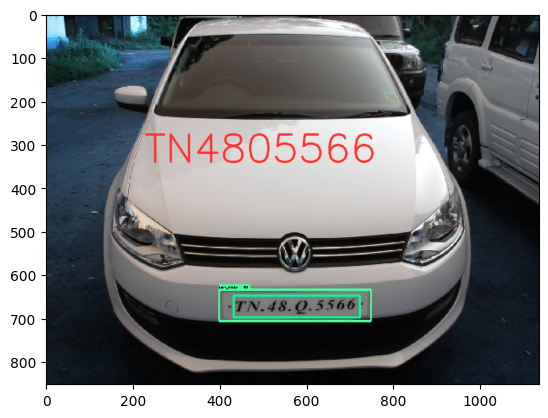

  licenseplateextractor.labels  \
0                           []   
1                  [TN4805566]   
2                   [INAQ3044]   
3                   [EGB62644]   
4                   [LEM446A4]   
5        [4II982A7A, 770L7726]   

                        licenseplateextractor.bboxes  \
0                                                 []   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[298, 238], [398, 238], [398, 264], [298, 26...   
3  [[[178, 430], [300, 430], [300, 462], [178, 46...   
4  [[[263, 465], [383, 465], [383, 501], [263, 50...   
5  [[[2263, 398], [2347, 398], [2347, 436], [2263...   

                   licenseplateextractor.scores  
0                                            []  
1                           [0.765264012834225]  
2                          [0.5979598335637649]  
3                          [0.8205181373232121]  
4                         [0.37683450003837526]  
5  [0.005999226930693703, 0.041628318390644674]  


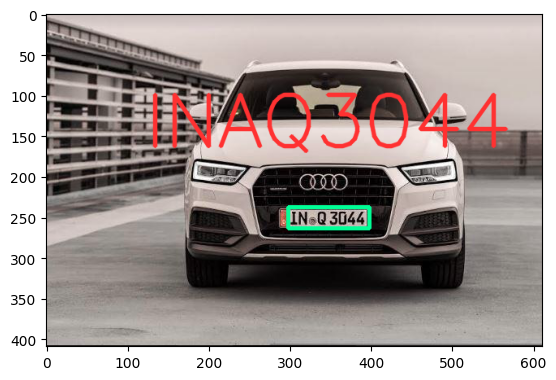

  licenseplateextractor.labels  \
0                           []   
1                  [TN4805566]   
2                   [INAQ3044]   
3                   [EGB62644]   
4                   [LEM446A4]   
5        [4II982A7A, 770L7726]   

                        licenseplateextractor.bboxes  \
0                                                 []   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[298, 238], [398, 238], [398, 264], [298, 26...   
3  [[[178, 430], [300, 430], [300, 462], [178, 46...   
4  [[[263, 465], [383, 465], [383, 501], [263, 50...   
5  [[[2263, 398], [2347, 398], [2347, 436], [2263...   

                   licenseplateextractor.scores  
0                                            []  
1                           [0.765264012834225]  
2                          [0.5979598335637649]  
3                          [0.8205181373232121]  
4                         [0.37683450003837526]  
5  [0.005999226930693703, 0.041628318390644674]  


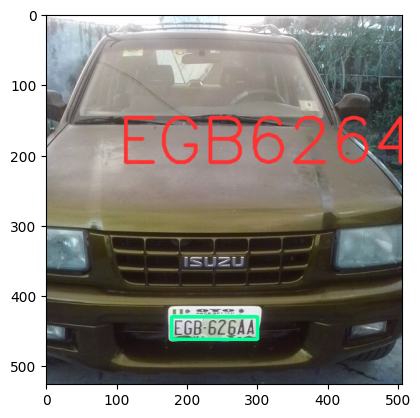

  licenseplateextractor.labels  \
0                           []   
1                  [TN4805566]   
2                   [INAQ3044]   
3                   [EGB62644]   
4                   [LEM446A4]   
5        [4II982A7A, 770L7726]   

                        licenseplateextractor.bboxes  \
0                                                 []   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[298, 238], [398, 238], [398, 264], [298, 26...   
3  [[[178, 430], [300, 430], [300, 462], [178, 46...   
4  [[[263, 465], [383, 465], [383, 501], [263, 50...   
5  [[[2263, 398], [2347, 398], [2347, 436], [2263...   

                   licenseplateextractor.scores  
0                                            []  
1                           [0.765264012834225]  
2                          [0.5979598335637649]  
3                          [0.8205181373232121]  
4                         [0.37683450003837526]  
5  [0.005999226930693703, 0.041628318390644674]  


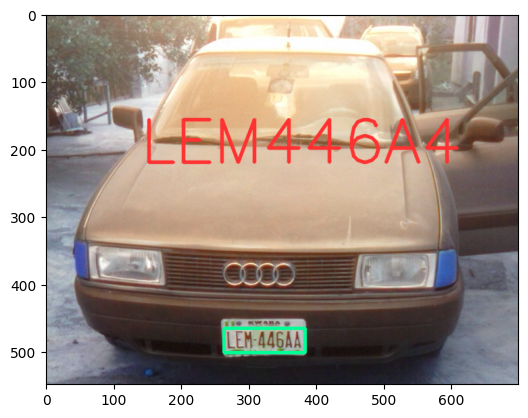

  licenseplateextractor.labels  \
0                           []   
1                  [TN4805566]   
2                   [INAQ3044]   
3                   [EGB62644]   
4                   [LEM446A4]   
5        [4II982A7A, 770L7726]   

                        licenseplateextractor.bboxes  \
0                                                 []   
1  [[[432, 648], [723, 648], [723, 698], [432, 69...   
2  [[[298, 238], [398, 238], [398, 264], [298, 26...   
3  [[[178, 430], [300, 430], [300, 462], [178, 46...   
4  [[[263, 465], [383, 465], [383, 501], [263, 50...   
5  [[[2263, 398], [2347, 398], [2347, 436], [2263...   

                   licenseplateextractor.scores  
0                                            []  
1                           [0.765264012834225]  
2                          [0.5979598335637649]  
3                          [0.8205181373232121]  
4                         [0.37683450003837526]  
5  [0.005999226930693703, 0.041628318390644674]  


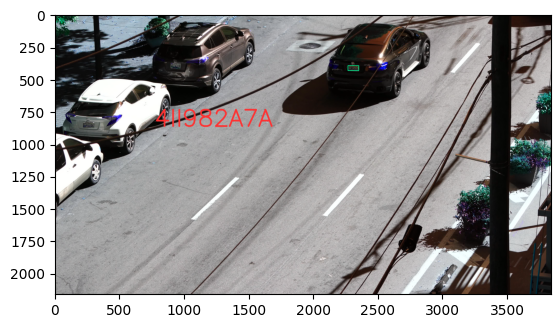

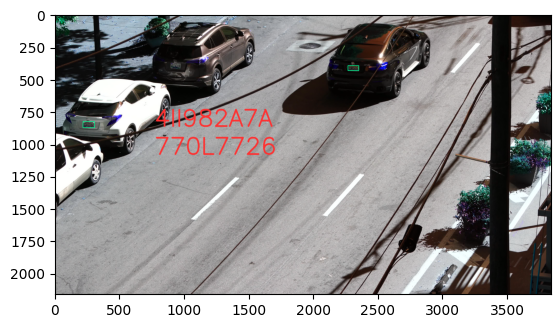

In [30]:
dataframe = response.batch.frames
annotate_image_ocr(dataframe, 'frame0_plate0.png', frame_id = 0)
annotate_image_ocr(dataframe, 'test_image_1.png', frame_id = 1)
annotate_image_ocr(dataframe, 'test_image_2.png', frame_id = 2)
annotate_image_ocr(dataframe, 'car10.jpg', frame_id = 3)
annotate_image_ocr(dataframe, 'car6.jpg', frame_id = 4)
annotate_image_ocr(dataframe, 'ezgif-frame-001.jpg', frame_id = 5)